# Code for sparse coding of spectrotemporal data
*Nhat Le, Sep 2017*

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import scipy.io.wavfile
import scipy.signal
import glob
import skimage.io
from sklearn.decomposition import PCA
import seaborn as sns
import os.path

%matplotlib inline

## Core functions for updating s and A

In [83]:
def T(u, lamb, norm_type):
    '''Threshold function with the appropriate norm type (L0 or L1)'''
    if norm_type == 'L0':
        return max(u, 0.0)
    elif norm_type == 'L1':
        return max(u - lamb, 0.0)
    else:
        raise ValueError('Invalid norm type')

# Vectorized version of T        
T_vec = np.vectorize(T)
    
def find_s(tau, A, y, lamb, niter=100, update='paper', verbose=False):
    '''Perform LCA to find the sparse representation s, given a dictionary
    of features, A, and target y. Returns optimal s, and best cost.
    lamb: weight of sparsity constraint 
    tau: learning rate'''
    # Initialize
    best_cost = np.inf
    cost_prev = np.inf
    y = y[:, np.newaxis]
    s = np.zeros((A.shape[1], 1), dtype='float')
    best_s = np.zeros((A.shape[1], 1), dtype='float')
    u = np.zeros((A.shape[1], 1), dtype='float')
    
    # Start competition
    for i in range(niter):
        print('Starting iteration #', i, '...')
        if update == 'direct':
            ds = np.dot(A.T, y) - np.dot(np.dot(A.T, A), s) - np.sign(s)
            s += ds * tau
        elif update == 'paper':
            du = np.dot(A.T, y) - np.dot(np.dot(A.T, A), s) - np.sign(s)
            
            u += du * tau
            print(u)
            s = T_vec(u, lamb, norm_type='L1')
            print(s)
            
        cost = 0.5 * np.linalg.norm(y - np.dot(A, s))**2 + lamb * np.linalg.norm(s, ord=1)
        if cost <= cost_prev:
            tau *= 1.05
        else:
            tau *= 0.5
        
        cost_prev = cost
            
        if cost < best_cost:
            best_cost = cost
            best_s = s
        
        if verbose:
            print('Cost = ', cost, '. tau =', tau)
    print('Best cost = ', best_cost, 'Best s =', best_s.T)
    return best_s, best_cost


def find_s_batch(tau, A, Y, lamb, niter=100, update='paper', verbose=False):
    '''Find s for each target, given a collection of targets Y.
    Returns a matrix S: n_neurons x n_targets, and the best cost
    lamb: weight of sparsity constraint 
    tau: learning rate'''
    best_cost = np.inf
    cost_prev = np.inf
    S = np.zeros((A.shape[1], Y.shape[1]), dtype='float')
    best_S = np.zeros((A.shape[1], Y.shape[1]), dtype='float')
    U = np.zeros((A.shape[1], Y.shape[1]), dtype='float')
    for i in range(niter):
        print('Starting iteration #', i, '...')
        if update == 'direct':
            ds = np.dot(A.T, Y) - np.dot(np.dot(A.T, A), S) - np.sign(S)
            S += ds * tau
        elif update == 'paper':
            du = np.dot(A.T, Y) - np.dot(np.dot(A.T, A), S) - np.sign(S)
            
            U += du * tau
            
            S = T_vec(U, lamb, norm_type='L1')
            
        diff = (Y - np.dot(A, S)).ravel()
        cost = 0.5 * np.linalg.norm(diff)**2 + lamb * np.linalg.norm(S.ravel(), ord=1)
        #print('cost: ', cost)
        if cost <= cost_prev:
            tau *= 1.05
        else:
            tau *= 0.5
        
        cost_prev = cost
            
        if cost < best_cost:
            best_cost = cost
            best_S = S
        
        if verbose:
            print('Cost = ', cost, '. tau =', tau)
    print('Best cost = ', best_cost)
    return best_S, best_cost

In [84]:
def learn_step(y, A, s, eta, theta):
    '''Update the dictionary A of receptive fields, given the vector s 
    eta: learning rate to match s
    theta: learning rate used for de-correlating columns of A'''
    s = s[:, np.newaxis]
    y = y[:, np.newaxis]
    r = y - np.dot(A, s)
    A_new = A + eta * (np.dot(r, s.T)) + theta * (A - np.dot(A, np.dot(A.T, A)))
    return A_new

def learn_step_batch(Y, A, S, eta, theta):
    '''Update the dictionary A of receptive fields, given the matrix S of all activity vectors,
    and Y, a matrix containing all the training examples.
    eta: learning rate to match s
    theta: learning rate used for de-correlating columns of A'''
    R = Y - np.dot(A, S)
    A_new = A + eta * (np.dot(R, S.T)) + theta * (A - np.dot(A, np.dot(A.T, A)))
    return A_new

def do_multiple_learn_steps(y, A, s, eta, theta, nsteps=10, verbose=False):
    '''Perform multiple steps of learning A
    eta: learning rate to match s
    theta: learning rate used for de-correlating columns of A'''
    diff = (y - np.dot(A, s)).ravel()
    cost = 0.5 * np.linalg.norm(diff)**2 + lamb * np.linalg.norm(s.ravel(), ord=1)
    prev_cost = cost
    best_cost = cost
    A_best = A
    for i in range(nsteps):
        if y.ndim == 1: # Single example
            A = learn_step(y, A, s, eta, theta)
            cost = np.linalg.norm(y - np.dot(A, s))**2
        else: # batch
            assert(y.shape[1] == s.shape[1])
            A = learn_step_batch(y, A, s, eta, theta)
            diff = (y - np.dot(A, s)).ravel()
            cost = 0.5 * np.linalg.norm(diff)**2 + lamb * np.linalg.norm(s.ravel(), ord=1)
            #cost = np.linalg.norm(y - np.dot(A, s))**2
        if verbose:
            #print(A[0,:])
            print('Cost = ', cost, 'eta = ', eta, 'theta = ', theta)
        if cost < best_cost:
            best_cost = cost
            A_best = A
            
        if cost <= prev_cost:
            eta *= 1.05
            theta *= 1.05
        else:
            eta *= 0.5
            theta *= 0.5
        
        prev_cost = cost
    print('Best cost = ', best_cost)
        
    return A_best, best_cost

def find_optimal_A(y, s):
    '''Analytical solution for the best matrix A to match s'''
    assert(s.shape[1] == 1)
    y = y[:, np.newaxis]
    n = np.dot(s.T, s)[0,0]
    #print(s.shape, y.shape)
    return np.dot(y, 1.0 / n * s.T)

## Read sound files & compute spectrograms

In [4]:
def logfsgram(X, N=1024, SR=8000, WIN=1024, NOV=512, FMIN=80, BPO=12):
    '''Create a spectrogram whose frequency is log-sampled
    X: signal X is input signal; N is parent FFT window; SR is the source samplerate.
    WIN is actual window length within FFT, NOV is number of overlapping 
    points between successive windows.
    Optional FMIN is the lowest frequency to display (80Hz);
    BPO is the number of bins per octave (12).
    MX returns the nlogbin x nfftbin mapping matrix;
    sqrt(MX'*(Y.^2)) is an approximation to the original FFT
    spectrogram that Y is based on, suitably blurred by going 
    through the log-F domain.
    Source: dpwe@ee.columbia.edu
'''
    _,_,XX = scipy.signal.spectrogram(X, fs=SR, nfft=WIN, nperseg=N, noverlap=NOV)
    fratio = 2.0**(1 / BPO)
    nbins = np.floor(np.log((SR / 2) / FMIN) / np.log(fratio))
    fftfrqs = np.arange(N/2 + 1) * (SR / N)
    nfftbins = N/2 + 1
    logffrqs = FMIN * np.exp(np.log(2) * np.arange(nbins) / BPO)
    logfbws = logffrqs * (fratio - 1)
    logfbws = np.maximum(logfbws, SR/N)
    ovfctr = 0.5475

    replogffrqs = np.repeat(logffrqs[:,np.newaxis], nfftbins, axis=1)
    repfftfrqs = np.tile(fftfrqs, (int(nbins), 1))
    replogfbws = np.repeat(ovfctr * logfbws[:,np.newaxis], nfftbins, axis=1)

    freqdiff = (replogffrqs - repfftfrqs) / replogfbws
    mx = np.exp(-0.5 * freqdiff**2)
    divby = np.sqrt(2 * np.sum(mx**2, axis=1))
    divby = np.repeat(divby[:,np.newaxis], nfftbins, axis=1)
    mx = mx / divby
    spectrogram = np.sqrt(np.dot(mx, np.abs(XX)**2))
    return spectrogram, XX, f, t

In [20]:
fs, sound = scipy.io.wavfile.read('./PDA/PDAm/16k/001/PDAm01_001_1.wav')

In [26]:
glob.glob('./PDA/PDAm/16k/*/*_2.wav')

['./PDA/PDAm/16k\\001\\PDAm01_001_2.wav',
 './PDA/PDAm/16k\\001\\PDAm01_002_2.wav',
 './PDA/PDAm/16k\\001\\PDAm01_003_2.wav',
 './PDA/PDAm/16k\\001\\PDAm01_004_2.wav',
 './PDA/PDAm/16k\\001\\PDAm01_005_2.wav',
 './PDA/PDAm/16k\\001\\PDAm01_006_2.wav',
 './PDA/PDAm/16k\\001\\PDAm01_007_2.wav',
 './PDA/PDAm/16k\\001\\PDAm01_008_2.wav',
 './PDA/PDAm/16k\\001\\PDAm01_009_2.wav',
 './PDA/PDAm/16k\\001\\PDAm01_010_2.wav',
 './PDA/PDAm/16k\\001\\PDAm01_011_2.wav',
 './PDA/PDAm/16k\\001\\PDAm01_012_2.wav',
 './PDA/PDAm/16k\\001\\PDAm01_013_2.wav',
 './PDA/PDAm/16k\\001\\PDAm01_014_2.wav',
 './PDA/PDAm/16k\\001\\PDAm01_015_2.wav',
 './PDA/PDAm/16k\\001\\PDAm01_016_2.wav',
 './PDA/PDAm/16k\\001\\PDAm01_017_2.wav',
 './PDA/PDAm/16k\\001\\PDAm01_018_2.wav',
 './PDA/PDAm/16k\\001\\PDAm01_019_2.wav',
 './PDA/PDAm/16k\\001\\PDAm01_020_2.wav',
 './PDA/PDAm/16k\\001\\PDAm01_021_2.wav',
 './PDA/PDAm/16k\\001\\PDAm01_022_2.wav',
 './PDA/PDAm/16k\\001\\PDAm01_023_2.wav',
 './PDA/PDAm/16k\\001\\PDAm01_024_

In [6]:
def read_song_file(type):
    '''Read song files of the appropriate type.
    Returns the combined sound and the sampling rate, fs'''
    if type == 'human':
        # Read the American English files
        soundfiles = glob.glob('./American-English/*/*.wav')
        sound_combined = np.zeros(0)
        for file in soundfiles:
            fs, sound = scipy.io.wavfile.read(file)
            sound_trim = np.trim_zeros(sound)
            sound_combined = np.concatenate((sound_combined, sound_trim))
    elif type == 'finch_50':
        # Read bird song file
        fs, sound_combined = scipy.io.wavfile.read('./songs_50_test_bird_0.15s.wav')
        sound_combined = sound_combined[:,0]
    elif type == 'pda':
        # Read the PDA data files
        soundfiles = glob.glob('./PDA/PDAm/16k/*/*_2.wav')[:100]
        sound_combined = np.zeros(0)
        for idx, file in enumerate(soundfiles):
            print('Reading file', idx, ' of ', len(soundfiles))
            fs, sound = scipy.io.wavfile.read(file)
            sound_combined = np.concatenate((sound_combined, sound))
    else:
        raise ValueError('Invalid file type')
        
    return sound_combined, fs

In [56]:
def make_spectrogram_multifile(type, n):
    if type == 'pda':
        # Read the PDA data files
        soundfiles = glob.glob('./PDA/PDAm/16k/*/*_2.wav')[:n]
        #sound_combined = np.zeros(0)
        for idx, file in enumerate(soundfiles):
            print('Reading file', idx, ' of ', len(soundfiles))
            fs, sound = scipy.io.wavfile.read(file)
            f,t,spectrogram = multitaper_spec(sound, fs=fs, nadvance=200, nperseg=4096*4)
            if idx == 0:
                sound_combined = spectrogram
            else:
                sound_combined = np.hstack((sound_combined, spectrogram))
    return f, sound_combined



In [68]:
logspec.shape

(256, 22711)

In [69]:
s.shape

(8193, 22711)

0.0144661939377


Reading file 0  of  50
Reading file 1  of  50
Reading file 2  of  50
Reading file 3  of  50
Reading file 4  of  50
Reading file 5  of  50
Reading file 6  of  50
Reading file 7  of  50
Reading file 8  of  50
Reading file 9  of  50
Reading file 10  of  50
Reading file 11  of  50
Reading file 12  of  50
Reading file 13  of  50
Reading file 14  of  50


C:\Users\Le\Anaconda2\envs\py36\lib\site-packages\ipykernel\__main__.py:11: RuntimeWarning: divide by zero encountered in log10


Reading file 15  of  50
Reading file 16  of  50
Reading file 17  of  50
Reading file 18  of  50
Reading file 19  of  50
Reading file 20  of  50
Reading file 21  of  50
Reading file 22  of  50
Reading file 23  of  50
Reading file 24  of  50
Reading file 25  of  50
Reading file 26  of  50
Reading file 27  of  50
Reading file 28  of  50
Reading file 29  of  50
Reading file 30  of  50
Reading file 31  of  50
Reading file 32  of  50
Reading file 33  of  50
Reading file 34  of  50
Reading file 35  of  50
Reading file 36  of  50
Reading file 37  of  50
Reading file 38  of  50
Reading file 39  of  50
Reading file 40  of  50
Reading file 41  of  50
Reading file 42  of  50
Reading file 43  of  50
Reading file 44  of  50
Reading file 45  of  50
Reading file 46  of  50
Reading file 47  of  50
Reading file 48  of  50
Reading file 49  of  50


Error: file exists. Skipped writing


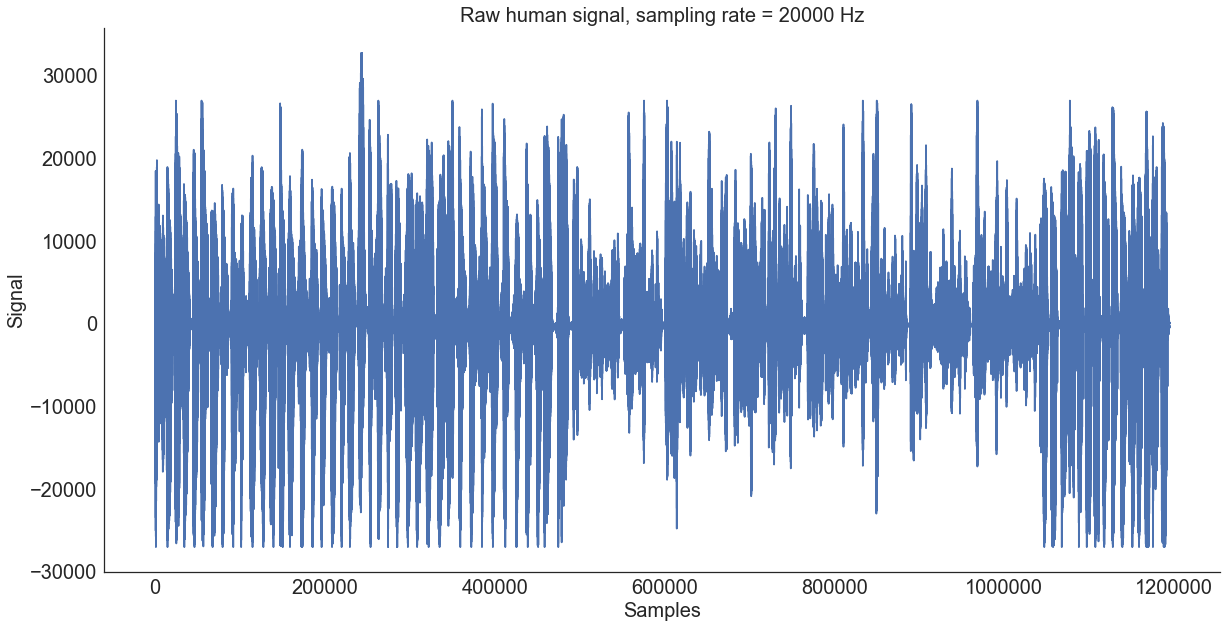

In [50]:
type = 'human'
with sns.axes_style('white'):
    plt.figure(figsize=(20, 10))
    sound_combined, fs = read_song_file(type)
    nsamples = len(sound_combined)
    sound_len_secs = nsamples / fs
    plt.plot(sound_combined)
    plt.xlabel('Samples', fontsize=20)
    plt.ylabel('Signal', fontsize=20)
    plt.title('Raw %s signal, sampling rate = %d Hz' % (type, fs), fontsize=20);
    sns.despine()
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
filename = 'waveform_human_171004.pdf'
if not os.path.isfile(filename):
    plt.savefig(filename)
else:
    print('Error: file exists. Skipped writing')

In [7]:
#p=TW determines spatial and temporal resolution
#k runs from 1,2,...2p-1, are the orthogonal modes which serve as 'samples' of the fft

In [11]:
def my_spectrogram(x):
    '''TODO: Implement multitapering with multiple dpss functions'''
    start = 0
    seg = sound_combined[start:start+nperseg]
    np.fft.fft(seg * window).shape

In [62]:
def multitaper_spec(X, fs=20000, nadvance=200, slepian_len=500, nperseg=4096*4, NW=1):
    '''Perform a dpss multitapering
    Returns the spectrogram, frequency (f) and time ticks (t)'''

    # Use slepian window of width 0.3
    window = scipy.signal.slepian(M=slepian_len, width=NW / slepian_len)
    window = np.lib.pad(window, (0, nperseg - slepian_len), 'constant', constant_values=(0, 0))
    noverlap = len(window) - nadvance

    f,t,spectrogram = scipy.signal.spectrogram(X, fs, window=window, noverlap=noverlap)
    spectrogram = 20 * np.log10(spectrogram) #Units: dB
    
    return (f, t, spectrogram)

def sample_logspec(spectrogram, f, nsamples=256, fmin=100.0, fmax=4000.0):
    '''Sample the spectrogram tollect the required number of samples
    in frequency from fmin to fmax, logarithmically spaced
    Returns the spectrogram and the frequencies sampled'''
    # Frequencies to sample
    spacing = (np.log(fmax) - np.log(fmin)) / (nsamples - 1)
    print(spacing)
    logfreqs = np.log(fmin) + np.arange(nsamples) * spacing
    freqs = np.exp(logfreqs)
    

    # Sampled version
    row_ids = []
    for freq in freqs:
        row_ids.append(len(f[f < freq]))

    logspec = spectrogram[row_ids,:]
    return (logspec, freqs)

def format_func_spec(value, tick_number):
    '''Format tick marks for spectrogram plot'''
    if value >= len(freqs):
        label = max(freqs)
    else:
        label = freqs[int(value)]
    return int(np.round(label, -2))

def format_func_pcs(value, tick_number):
    '''Formatting axis ticks for the PC plot'''
    return value

In [39]:
f,t,spectrogram = multitaper_spec(sound_combined[:10000000], fs=fs, nadvance=200, nperseg=4096)


In [71]:
f, spectrogram = make_spectrogram_multifile('pda', 50)
logspec, freqs = sample_logspec(spectrogram, f, fmin=100.0, fmax=4000)

Reading file 0  of  50
Reading file 1  of  50
Reading file 2  of  50
Reading file 3  of  50
Reading file 4  of  50
Reading file 5  of  50
Reading file 6  of  50
Reading file 7  of  50
Reading file 8  of  50
Reading file 9  of  50
Reading file 10  of  50
Reading file 11  of  50
Reading file 12  of  50
Reading file 13  of  50
Reading file 14  of  50


C:\Users\Le\Anaconda2\envs\py36\lib\site-packages\ipykernel\__main__.py:11: RuntimeWarning: divide by zero encountered in log10


Reading file 15  of  50
Reading file 16  of  50
Reading file 17  of  50
Reading file 18  of  50
Reading file 19  of  50
Reading file 20  of  50
Reading file 21  of  50
Reading file 22  of  50
Reading file 23  of  50
Reading file 24  of  50
Reading file 25  of  50
Reading file 26  of  50
Reading file 27  of  50
Reading file 28  of  50
Reading file 29  of  50
Reading file 30  of  50
Reading file 31  of  50
Reading file 32  of  50
Reading file 33  of  50
Reading file 34  of  50
Reading file 35  of  50
Reading file 36  of  50
Reading file 37  of  50
Reading file 38  of  50
Reading file 39  of  50
Reading file 40  of  50
Reading file 41  of  50
Reading file 42  of  50
Reading file 43  of  50
Reading file 44  of  50
Reading file 45  of  50
Reading file 46  of  50
Reading file 47  of  50
Reading file 48  of  50
Reading file 49  of  50
0.0144661939377


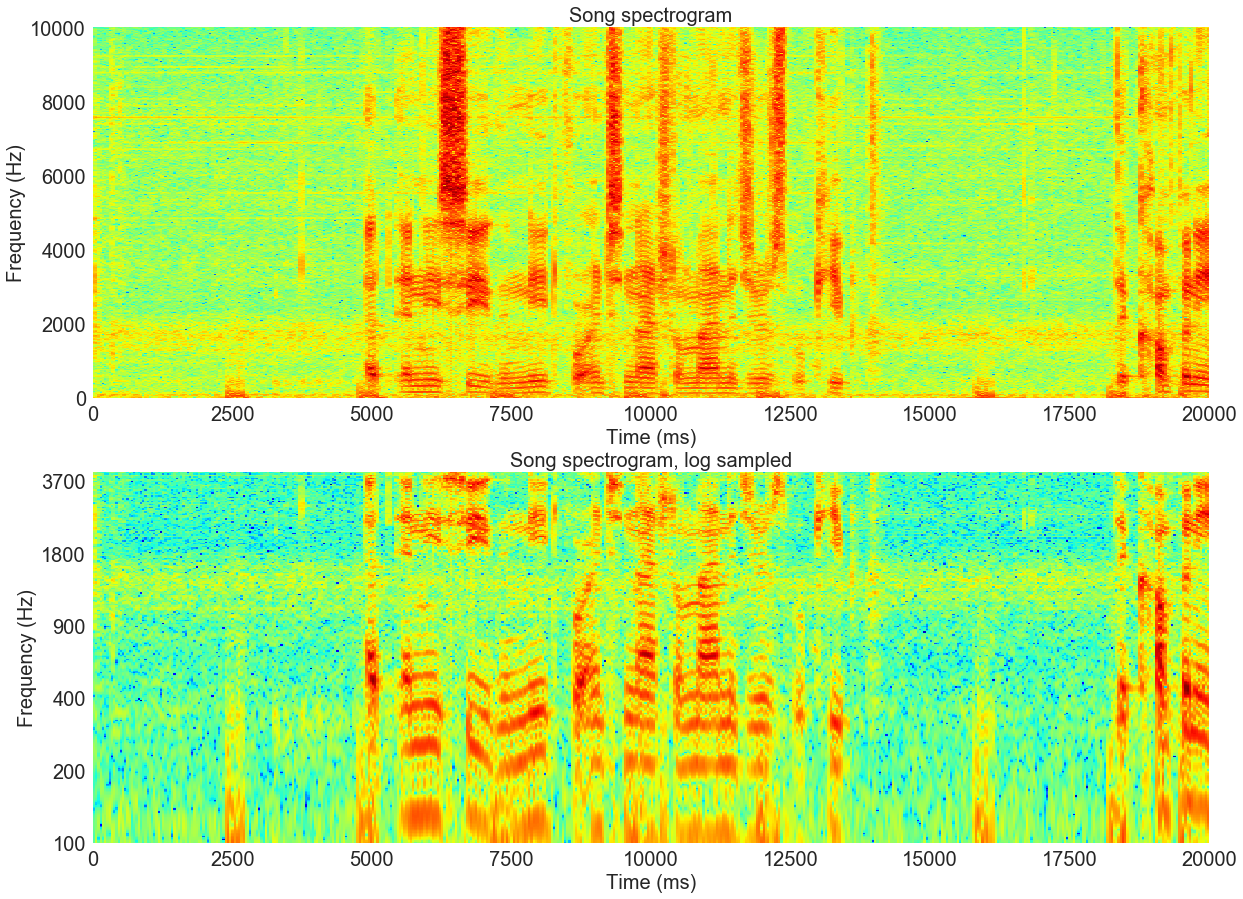

In [77]:
# Time and frequency ranges for plotting
fmin = 0
fmax = 10000 #Hz
tmin = 0
tmax = 20000 #ms
f_start = len(f[f<fmin])
f_end = len(f[f<fmax])
#t_start = len(t[t<tmin])
#t_end = len(t[t<tmax/1000])
t_start = 0
t_end = 500


# Plot the spectrogram and log spectrogram
fig, ax = plt.subplots(2, 1, figsize=(20,15))
ax[0].imshow(np.flipud(spectrogram[f_start:f_end,t_start:t_end]), cmap='jet', aspect='auto',
           extent=[tmin, tmax, fmin, fmax])
ax[0].grid(False)
ax[0].set_title('Song spectrogram', fontsize=20)
ax[0].set_xlabel('Time (ms)', fontsize=20)
ax[0].set_ylabel('Frequency (Hz)', fontsize=20);
ax[0].tick_params(axis='both', which='major', labelsize=20)

ax[1].imshow(np.flipud(logspec[:,t_start:t_end]), cmap='jet', aspect='auto',
           extent=[tmin, tmax, 0, len(freqs)])
ax[1].grid(False)
ax[1].set_title('Song spectrogram, log sampled', fontsize=20)
ax[1].set_xlabel('Time (ms)', fontsize=20)
ax[1].set_ylabel('Frequency (Hz)', fontsize=20);
ax[1].yaxis.set_major_formatter(plt.FuncFormatter(format_func_spec))
ax[1].tick_params(axis='both', which='major', labelsize=20)

In [53]:
spectrogram.shape

(8193, 5895)

Error: file exists. Skipped writing


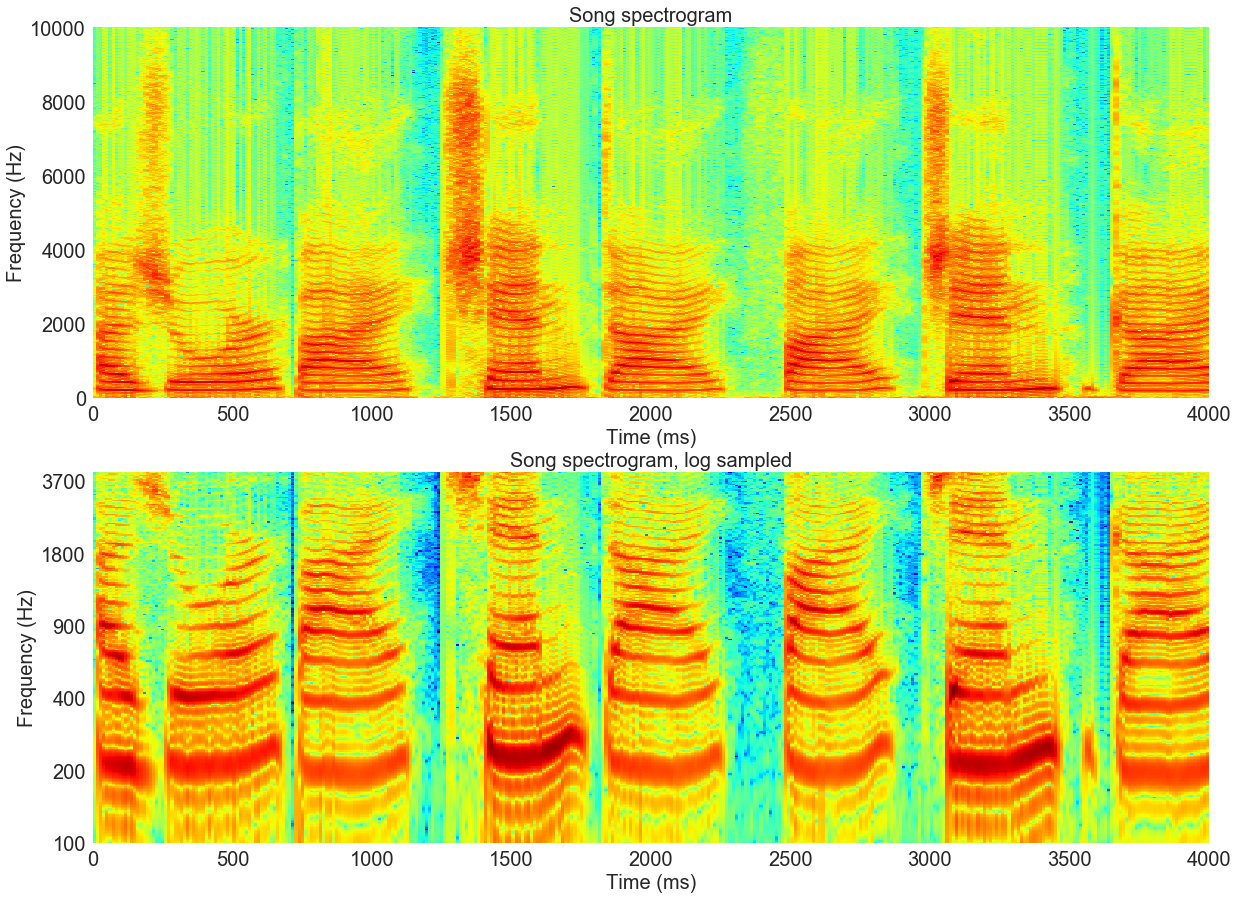

In [52]:
# Compute the spectrogram and log spectrogram
nadvance = 200
#f,t,spectrogram = multitaper_spec(sound_combined, fs=fs, nadvance=nadvance)
#logspec, freqs = sample_logspec(spectrogram, fmin=100.0, fmax=4000)

# Time and frequency ranges for plotting
fmin = 0
fmax = 10000 #Hz
tmin = 0
tmax = 4000 #ms
f_start = len(f[f<fmin])
f_end = len(f[f<fmax])
t_start = len(t[t<tmin])
t_end = len(t[t<tmax/1000])


# Plot the spectrogram and log spectrogram
fig, ax = plt.subplots(2, 1, figsize=(20,15))
ax[0].imshow(np.flipud(spectrogram[f_start:f_end,t_start:t_end]), cmap='jet', aspect='auto',
           extent=[tmin, tmax, fmin, fmax])
ax[0].grid(False)
ax[0].set_title('Song spectrogram', fontsize=20)
ax[0].set_xlabel('Time (ms)', fontsize=20)
ax[0].set_ylabel('Frequency (Hz)', fontsize=20);
ax[0].tick_params(axis='both', which='major', labelsize=20)

# For plotting
ax[1].imshow(np.flipud(logspec[:,t_start:t_end]), cmap='jet', aspect='auto',
           extent=[tmin, tmax, 0, len(freqs)])
ax[1].grid(False)
ax[1].set_title('Song spectrogram, log sampled', fontsize=20)
ax[1].set_xlabel('Time (ms)', fontsize=20)
ax[1].set_ylabel('Frequency (Hz)', fontsize=20);
ax[1].yaxis.set_major_formatter(plt.FuncFormatter(format_func_spec))
ax[1].tick_params(axis='both', which='major', labelsize=20)

filename = 'spectrogram_human_171004.pdf'
if not os.path.isfile(filename):
    plt.savefig(filename)
else:
    print('Error: file exists. Skipped writing')


## Segment the sound and perform PCA

In [98]:
# Segment into overlapping segments
spectrogram = logspec
segment_len = 20 #samples
segment_width = spectrogram.shape[0]
segment_step = 10 #samples
dt = segment_len * nadvance / fs * 1000 #length of each window in ms
segments_lst = []
for t_start in np.arange(0, spectrogram.shape[1] - segment_len, segment_step):
    segments_lst.append(spectrogram[:,t_start:(t_start + segment_len)])
    
# Do pca on each segment
X = np.zeros((segments_lst[0].shape[0] * segments_lst[0].shape[1], len(segments_lst)))
for idx, segment in enumerate(segments_lst):
    X[:,idx] = segment.ravel()
# Perform pca with whitening
pca = PCA(n_components=200, whiten=True)
pca.fit(X.T)
Y = pca.transform(X.T).T    

In [100]:
X.shape

(5120, 2270)

Error: file exists. Skipped writing


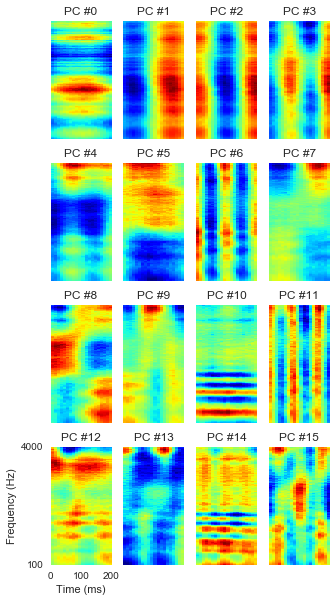

In [101]:
# Visualize principal components
n_show = 4 #number of rows to show. will show n_show x n_show pca components
fig, ax = plt.subplots(n_show, n_show, figsize=(5,10))
comp = pca.components_

for i in range(n_show):
    for j in range(n_show):
        idx = n_show*i + j
        component = comp[idx,:].reshape((segment_width, segment_len))
        ax[i][j].grid(False)
        ax[i][j].imshow(np.flipud(component), cmap='jet', aspect='auto', extent=[0, dt, 100, 4000])
        ax[i][j].set_title('PC #' + str(idx))
        ax[i][j].set_ylim([100, 4000])
        if i != n_show - 1 or j != 0:
            ax[i][j].set(xticklabels=[], yticklabels=[])
        else:
            ax[i][j].set_xlabel('Time (ms)')
            ax[i][j].set_ylabel('Frequency (Hz)')
            ax[i][j].yaxis.set_major_locator(plt.FixedLocator([100, 4000]))
            ax[i][j].yaxis.set_major_formatter(plt.FuncFormatter(format_func_pcs))

filename = 'PCs_human_171004.pdf'
if not os.path.isfile(filename):
    plt.savefig(filename)
else:
    print('Error: file exists. Skipped writing')

## Learning the sparse representation

In [126]:
# Set learning parameters
iters = 10 #number of iterations per s or A update
n_neurons = 800 #number of neurons
lamb = 0.1 #weight of sparsity constraint
tau = 0.01 #changed 0.1 to 0.01 10/1 #learning rate for s update
eta = 0.01 #learning rate for A update
theta = 0.001 #learning rate for A update (orthogonalizing component)

In [127]:
# Initialize and normalize A
A = np.random.rand(comp.shape[0], n_neurons)
A /= np.linalg.norm(A, axis=0)

In [128]:
nreps = 40
best_cost_s = np.inf
best_cost_A = np.inf
prev_cost_s = np.inf
prev_cost_A = np.inf
# Issue: In find_A: invalid value encountered in subtract
for i in range(nreps):
    print('#### Finding s, iteration ', i, '####')
    s,cost_s = find_s_batch(tau, A, Y, lamb, niter=iters, verbose=False)
    print('#### Finding A, iteration ', i, '####')

    A,cost_A = do_multiple_learn_steps(Y, A, s, eta=eta, theta=theta, nsteps=10, verbose=False)
    A /= np.linalg.norm(A, axis=0)
    
    if cost_s <= prev_cost_s:
        tau *= 1.0
    else:
        tau *= 1.0
    
    if cost_A <= prev_cost_A:
        eta *= 1.0
        theta *= 1.0
    else:
        eta *= 1.0
        theta *= 1.0
    
    print('(tau, eta, theta) = ', tau, eta, theta)
    prev_cost_s = cost_s
    prev_cost_A = cost_A
        
    if i > 0 and cost_A < best_cost_A:
        best_cost_s = cost_s
        best_cost_A = cost_A
        best_s = s
        best_A = A

#### Finding s, iteration  0 ####
Starting iteration # 0 ...
Starting iteration # 1 ...
Starting iteration # 2 ...
Starting iteration # 3 ...
Starting iteration # 4 ...
Starting iteration # 5 ...
Starting iteration # 6 ...
Starting iteration # 7 ...
Starting iteration # 8 ...
Starting iteration # 9 ...
Best cost =  225460.272468
#### Finding A, iteration  0 ####
Best cost =  223578.115193
(tau, eta, theta) =  0.01 0.01 0.001
#### Finding s, iteration  1 ####
Starting iteration # 0 ...
Starting iteration # 1 ...
Starting iteration # 2 ...
Starting iteration # 3 ...
Starting iteration # 4 ...
Starting iteration # 5 ...
Starting iteration # 6 ...
Starting iteration # 7 ...
Starting iteration # 8 ...
Starting iteration # 9 ...
Best cost =  205367.327667
#### Finding A, iteration  1 ####
Best cost =  156417.931002
(tau, eta, theta) =  0.01 0.01 0.001
#### Finding s, iteration  2 ####
Starting iteration # 0 ...
Starting iteration # 1 ...
Starting iteration # 2 ...
Starting iteration # 3 ...


Starting iteration # 1 ...
Starting iteration # 2 ...
Starting iteration # 3 ...
Starting iteration # 4 ...
Starting iteration # 5 ...
Starting iteration # 6 ...
Starting iteration # 7 ...
Starting iteration # 8 ...
Starting iteration # 9 ...
Best cost =  179296.395055
#### Finding A, iteration  19 ####
Best cost =  82087.9992937
(tau, eta, theta) =  0.01 0.01 0.001
#### Finding s, iteration  20 ####
Starting iteration # 0 ...
Starting iteration # 1 ...
Starting iteration # 2 ...
Starting iteration # 3 ...
Starting iteration # 4 ...
Starting iteration # 5 ...
Starting iteration # 6 ...
Starting iteration # 7 ...
Starting iteration # 8 ...
Starting iteration # 9 ...
Best cost =  179208.462504
#### Finding A, iteration  20 ####
Best cost =  81876.9348239
(tau, eta, theta) =  0.01 0.01 0.001
#### Finding s, iteration  21 ####
Starting iteration # 0 ...
Starting iteration # 1 ...
Starting iteration # 2 ...
Starting iteration # 3 ...
Starting iteration # 4 ...
Starting iteration # 5 ...
Sta

Starting iteration # 2 ...
Starting iteration # 3 ...
Starting iteration # 4 ...
Starting iteration # 5 ...
Starting iteration # 6 ...
Starting iteration # 7 ...
Starting iteration # 8 ...
Starting iteration # 9 ...
Best cost =  178436.692553
#### Finding A, iteration  38 ####
Best cost =  79907.22992
(tau, eta, theta) =  0.01 0.01 0.001
#### Finding s, iteration  39 ####
Starting iteration # 0 ...
Starting iteration # 1 ...
Starting iteration # 2 ...
Starting iteration # 3 ...
Starting iteration # 4 ...
Starting iteration # 5 ...
Starting iteration # 6 ...
Starting iteration # 7 ...
Starting iteration # 8 ...
Starting iteration # 9 ...
Best cost =  178417.781943
#### Finding A, iteration  39 ####
Best cost =  79861.8327125
(tau, eta, theta) =  0.01 0.01 0.001


In [135]:
599-409

190

In [134]:
t[:20]

array([ 0.4096,  0.4196,  0.4296,  0.4396,  0.4496,  0.4596,  0.4696,
        0.4796,  0.4896,  0.4996,  0.5096,  0.5196,  0.5296,  0.5396,
        0.5496,  0.5596,  0.5696,  0.5796,  0.5896,  0.5996])

In [124]:
s,cost_s = find_s_batch(0.1, A, Y, lamb, niter=40, verbose=True)

Starting iteration # 0 ...
Cost =  175027.327099 . tau = 0.10500000000000001
Starting iteration # 1 ...
Cost =  141712.764208 . tau = 0.11025000000000001
Starting iteration # 2 ...
Cost =  127191.348822 . tau = 0.11576250000000002
Starting iteration # 3 ...
Cost =  115842.480566 . tau = 0.12155062500000002
Starting iteration # 4 ...
Cost =  108136.644951 . tau = 0.12762815625000004
Starting iteration # 5 ...
Cost =  102340.725494 . tau = 0.13400956406250006
Starting iteration # 6 ...
Cost =  98277.3159496 . tau = 0.14071004226562506
Starting iteration # 7 ...
Cost =  95002.6347761 . tau = 0.14774554437890633
Starting iteration # 8 ...
Cost =  92631.8166311 . tau = 0.15513282159785166
Starting iteration # 9 ...
Cost =  90686.9826442 . tau = 0.16288946267774426
Starting iteration # 10 ...
Cost =  89183.2893989 . tau = 0.17103393581163148
Starting iteration # 11 ...
Cost =  87998.410309 . tau = 0.17958563260221305
Starting iteration # 12 ...
Cost =  86996.6511519 . tau = 0.188564914232323

In [107]:
cost_s

69484.9220891531

In [109]:
best_s.shape

(800, 2270)

Error: file exists. Skipped writing


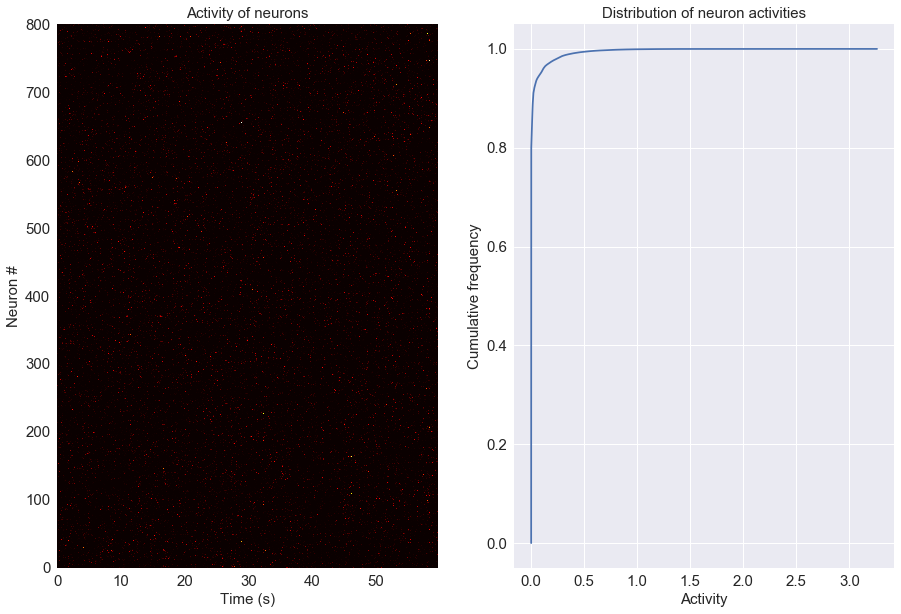

In [108]:
# Visualize the activities of neurons
fig, ax = plt.subplots(1, 2, figsize=(15, 10))

ax[0].imshow(best_s, cmap='hot', extent=[0, sound_len_secs, 0, n_neurons], aspect='auto')
#fig.colorbar(ax[0])
ax[0].set_xlabel('Time (s)', fontsize=15)
ax[0].set_ylabel('Neuron #', fontsize=15)
ax[0].grid(False)
ax[0].set_title('Activity of neurons', fontsize=15);
ax[0].tick_params(axis='both', which='major', labelsize=15)

#ax[0].xticks(fontsize=15)
#ax[0].yticks(fontsize=15);

s_activities = best_s.ravel()
ax[1].plot(np.sort(s_activities), np.arange(len(s_activities)) / len(s_activities))
ax[1].set_xlabel('Activity', fontsize=15)
ax[1].set_ylabel('Cumulative frequency', fontsize=15)
ax[1].set_title('Distribution of neuron activities', fontsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)



filename = 'neurons_activity_human_171005.pdf'
if not os.path.isfile(filename):
    plt.savefig(filename)
else:
    print('Error: file exists. Skipped writing')

## Reconstruction of the spectrogram

In [90]:
def reconstruct_from_A_s(A, S, pca, shape, segment_width, segment_len, Y=None):
    '''Reconstruct the spectrogram, given a dictionary A of receptive fields,
    and s: the activity of neurons'''
    Y = np.dot(A, S)
    Y_inverted = pca.inverse_transform(Y.T).T
    recons = np.zeros(shape)

    for ncol in range(Y.shape[1]):
        segment = np.reshape(Y_inverted[:,ncol], (segment_width, segment_len))
        start = ncol * segment_step
        recons[:,start:(start + segment_len)] += segment
    return recons

In [42]:
def reconstruct_from_pca(Y, pca, shape, segment_width, segment_len):
    '''Reconstruct the spectrogram, given its pca projection'''
    recons = np.zeros(shape)
    Y_inverted = pca.inverse_transform(Y.T).T
    for ncol in range(Y.shape[1]):
        segment = np.reshape(Y_inverted[:,ncol], (segment_width, segment_len))
        start = ncol * segment_step
        recons[:,start:(start + segment_len)] += segment
    return recons
    

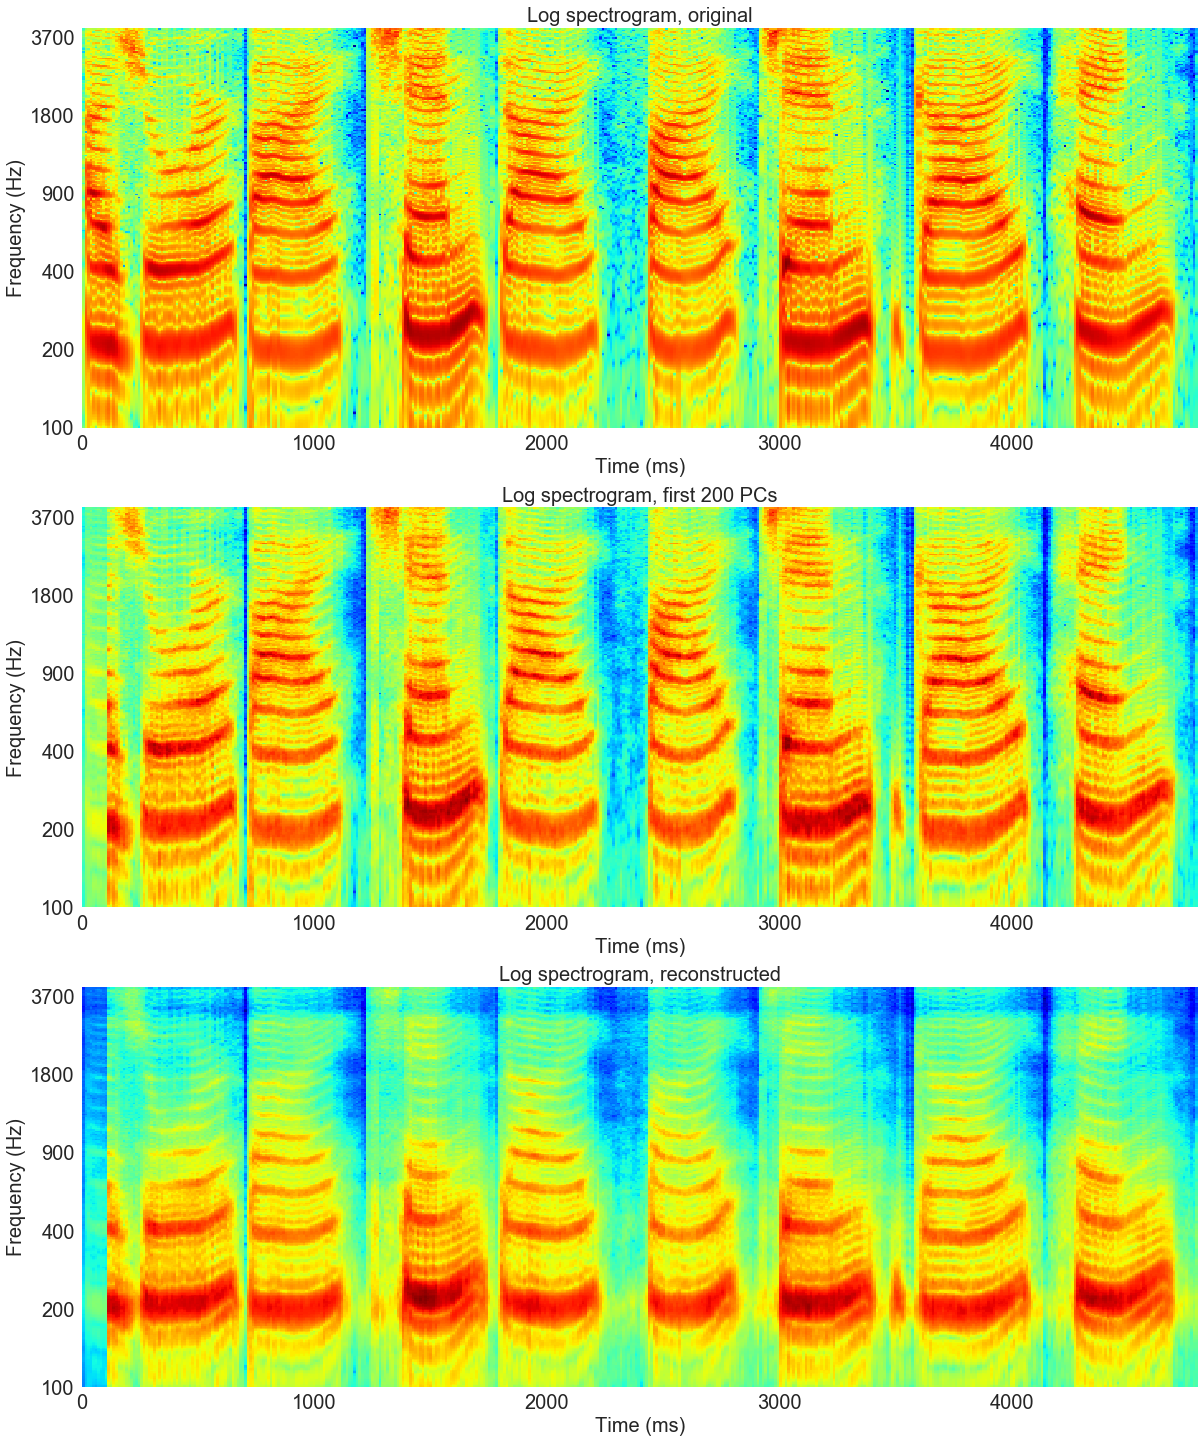

In [56]:
recons = reconstruct_from_A_s(best_A, best_s, pca, spectrogram.shape, segment_width, segment_len)
recons_pca = reconstruct_from_pca(Y, pca, spectrogram.shape, segment_width, segment_len)

# Time and frequency ranges for plotting
fmin = 0
fmax = 10000 #Hz
tmin = 0
tmax = 4800 #ms
f_start = len(f[f<fmin])
f_end = len(f[f<fmax])
t_start = len(t[t<tmin/1000])
t_end = len(t[t<tmax/1000])

logspec_n = (logspec - np.mean(logspec)) / np.std(logspec)
recons_n = (recons - np.mean(recons)) / np.std(recons)

# For plotting
fig, ax = plt.subplots(3, 1, figsize=(20,25))
ax[0].imshow(np.flipud(spectrogram[:,t_start:t_end]), cmap='jet', aspect='auto',
           extent=[tmin, tmax, 0, len(freqs)])
ax[0].grid(False)
ax[0].set_title('Log spectrogram, original', fontsize=20)
ax[0].set_xlabel('Time (ms)', fontsize=20)
ax[0].set_ylabel('Frequency (Hz)', fontsize=20);
ax[0].yaxis.set_major_formatter(plt.FuncFormatter(format_func_spec))
ax[0].tick_params(axis='both', which='major', labelsize=20)



ax[1].imshow(np.flipud(recons_pca[:,t_start:t_end]), cmap='jet', aspect='auto',
           extent=[tmin, tmax, 0, len(freqs)])
ax[1].grid(False)
ax[1].set_title('Log spectrogram, first 200 PCs', fontsize=20)
ax[1].set_xlabel('Time (ms)', fontsize=20)
ax[1].set_ylabel('Frequency (Hz)', fontsize=20);
ax[1].yaxis.set_major_formatter(plt.FuncFormatter(format_func_spec))
ax[1].tick_params(axis='both', which='major', labelsize=20)

# Plot the original vs the reconstructed songs
ax[2].imshow(np.flipud(recons_n[:,t_start:t_end]), cmap='jet', aspect='auto',
           extent=[tmin, tmax, 0, len(freqs)])
ax[2].grid(False)
ax[2].set_title('Log spectrogram, reconstructed', fontsize=20)
ax[2].set_xlabel('Time (ms)', fontsize=20)
ax[2].set_ylabel('Frequency (Hz)', fontsize=20);
ax[2].yaxis.set_major_formatter(plt.FuncFormatter(format_func_spec))
ax[2].tick_params(axis='both', which='major', labelsize=20)



filename = 'recons_comparison_human_171005_tau_change.pdf'
if not os.path.isfile(filename):
    plt.savefig(filename)
else:
    print('Error: file exists. Skipped writing')
    

## Visualize the receptive fields of the neurons

Error: file exists. Skipped writing


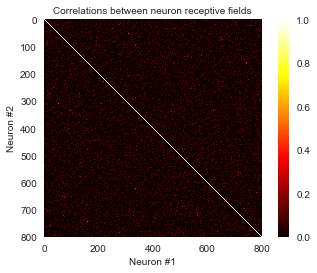

In [92]:
# Check the orthogonality of neurons
A_inv = np.dot(comp.T, best_A)
corr = np.dot(A_inv.T, A_inv)
plt.imshow(corr, cmap='hot')
plt.grid(False)
plt.colorbar()
plt.clim(0, 1)
plt.title('Correlations between neuron receptive fields', fontsize=10)
plt.xlabel('Neuron #1', fontsize=10)
plt.ylabel('Neuron #2', fontsize=10)

filename = 'correlations_human_171005.pdf'
if not os.path.isfile(filename):
    plt.savefig(filename)
else:
    print('Error: file exists. Skipped writing')

Error: file exists. Skipped writing


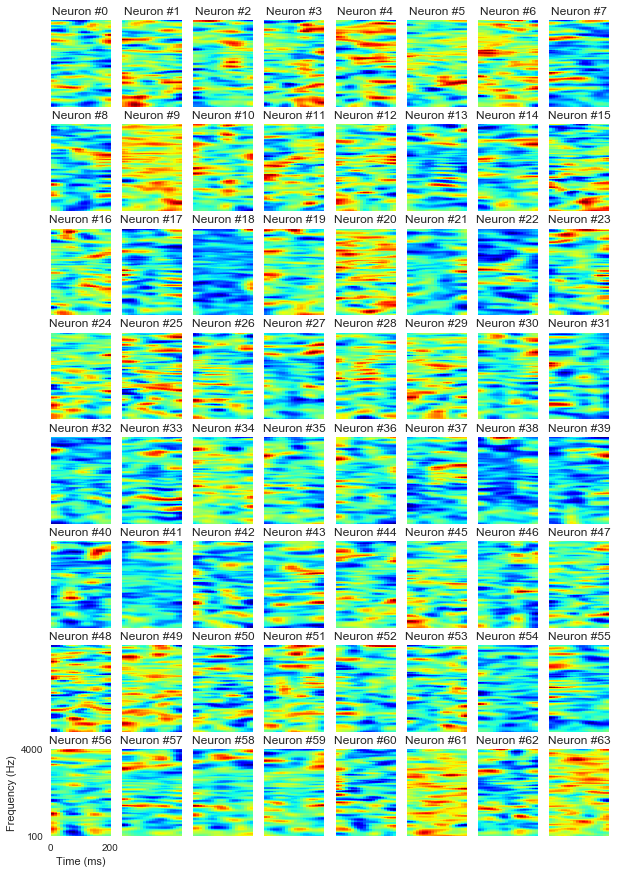

In [130]:
n_show = 8
A_inverted = pca.inverse_transform(best_A.T).T
fig, ax = plt.subplots(n_show, n_show, figsize=(10,15))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None,
            wspace=None, hspace=None)
for i in range(n_show):
    for j in range(n_show):
        seg = A_inv[:,n_show*i + j].reshape((segment_width, segment_len))
        
        # Filter
        filt = scipy.ndimage.filters.gaussian_filter(seg, sigma=2)
        
        idx = n_show*i + j
        ax[i][j].grid(False)
        ax[i][j].imshow(np.flipud(filt), cmap='jet', aspect='auto', extent=[0, dt, 100, 4000])
        #ax[i][j].set_yscale('log')
        ax[i][j].set_title('Neuron #' + str(idx))
        ax[i][j].set_ylim([100, 4000])
        if i != n_show - 1 or j != 0:
            ax[i][j].set(xticklabels=[], yticklabels=[])
        else:
            ax[i][j].set_xlabel('Time (ms)')
            ax[i][j].set_ylabel('Frequency (Hz)')
            #ax[i][j].yaxis.set_major_locator(plt.LogLocator(numticks=5))
            ax[i][j].yaxis.set_major_locator(plt.FixedLocator([100, 4000]))
            ax[i][j].yaxis.set_major_formatter(plt.FuncFormatter(format_func_pcs)) 
filename = 'receptive_fields_human_171004.pdf'
if not os.path.isfile(filename):
    plt.savefig(filename)
else:
    print('Error: file exists. Skipped writing')